# Mixture Manifold HMC with Jacobian Correction

This is not working because Zappa's algorithm leaves the distribution ON THE MANIFOLD invariant, not the true target distribution. Hence we are not targeting the correct distribution.

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import multivariate_normal, norm
from mixture_manifoldhmc_jacobian import MixtureManifoldHMCJacobian
from Manifolds.RotatedEllipse import RotatedEllipse

In [2]:
# Target Distribution 
Sigma = np.array([[1.0, 0.6], [0.6, 2.0]])        # Covariance Matrix of Target Distribution
mu = np.zeros(2)                                  # Mean of target distribution
target = multivariate_normal(mean=mu, cov=Sigma)

# Settings for sampling
n = 2            # Number of HMC samples per iteration
m = 100            # Number of Zappa samples per iteration
T = 0.5             # Total integration time
epsilon = 0.001    # Step size
M = np.eye(2)     # Coviariance Matrix for momentum distribution
alpha = 0.2       # Probability of using HMC
N = 20000         # Total number of samples

# Data for contour plot
xmin, xmax, xstep = -3, 3, 0.05
ymin, ymax, ystep = -3, 3, 0.05
x_grid, y_grid = np.mgrid[xmin:xmax:xstep, ymin:ymax:ystep]
contour_values = target.pdf(np.dstack((x_grid, y_grid)))

# Sample and plot
x0 = target.rvs()
samples, flags = MixtureManifoldHMCJacobian(x0, alpha=alpha, N=N, n=n, m=m, Sigma=Sigma, mu=mu, T=T, epsilon=epsilon, M=M)

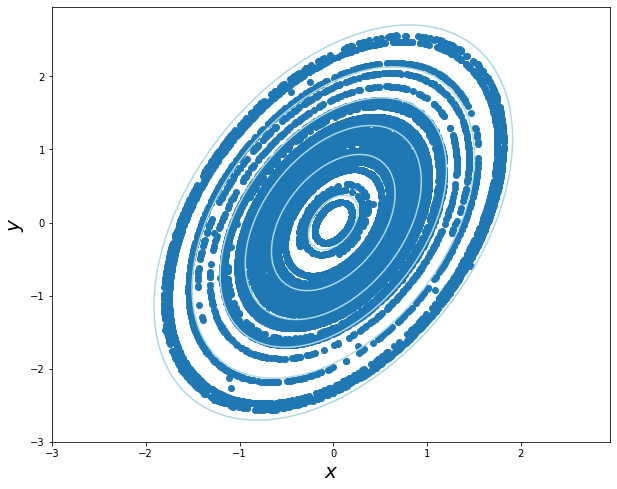

In [3]:
# Usual Samples
fig, ax = plt.subplots(figsize=(10, 8))
ax.scatter(samples[:, 0], samples[:,1])
ax.contour(x_grid, y_grid, contour_values, colors="lightblue")
ax.set_xlabel(r"$x$", fontsize=20)
ax.set_ylabel(r"$y$", fontsize=20)
plt.show()

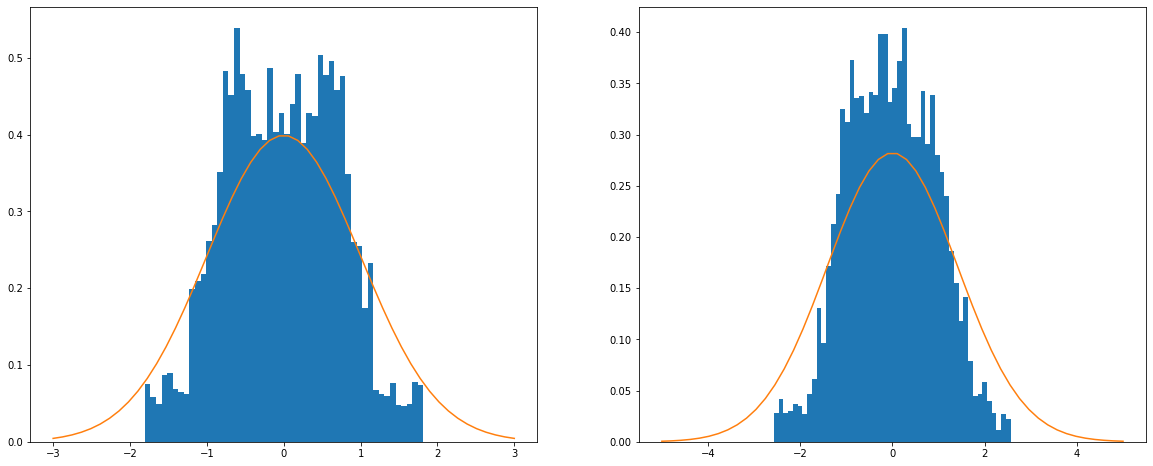

In [4]:
# marginals
marginal_x = norm(loc=mu[0], scale=np.sqrt(Sigma[0,0]))
marginal_y = norm(loc=mu[1], scale=np.sqrt(Sigma[1,1]))

# Plotting vars
xs = np.linspace(-3, 3)
ys = np.linspace(-5, 5)

fig, ax = plt.subplots(ncols=2, figsize=(20, 8))

# X space
_ = ax[0].hist(samples[:, 0], bins=50, density=True)
ax[0].plot(xs, marginal_x.pdf(xs))

# Y space
_ = ax[1].hist(samples[:, 1], bins=50, density=True)
ax[1].plot(ys, marginal_y.pdf(ys))

plt.show()

# Correcting for Jacobian

In [5]:
# Get the samples obtined via zappa sampling
zappa_samples = samples[flags == 1]

# find jacobian corrections
corrections = np.array([
    RotatedEllipse(mu, Sigma, target.pdf(sample)).J(target.pdf(sample)) for sample in zappa_samples
])

# Divide!
corrected_samples = (zappa_samples.T / corrections).T #(zappa_samples.T / corrections).T

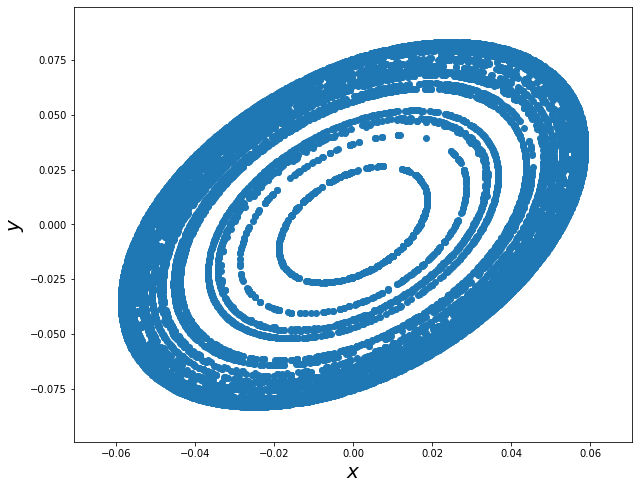

In [6]:
fig, ax = plt.subplots(figsize=(10, 8))
ax.scatter(corrected_samples[:, 0], corrected_samples[:,1])
#ax.contour(x_grid, y_grid, contour_values, colors="lightblue")
ax.set_xlabel(r"$x$", fontsize=20)
ax.set_ylabel(r"$y$", fontsize=20)
plt.show()

# Correcting once again using z

In [74]:
samples

array([[-0.16754748, -0.89262735],
       [-0.0132417 , -0.07054657],
       [-0.0132417 , -0.07054657],
       ...,
       [ 0.01148763, -0.0644287 ],
       [ 0.01270571, -0.06335823],
       [ 0.00610102, -0.06874176]])

In [73]:
corrected_samples

array([[-0.0132417 , -0.07054657],
       [-0.0132417 , -0.07054657],
       [-0.0132417 , -0.07054657],
       ...,
       [ 0.01148763, -0.0644287 ],
       [ 0.01270571, -0.06335823],
       [ 0.00610102, -0.06874176]])

In [76]:
new_corrected_samples = (corrected_samples.T / target.pdf(zappa_samples)).T

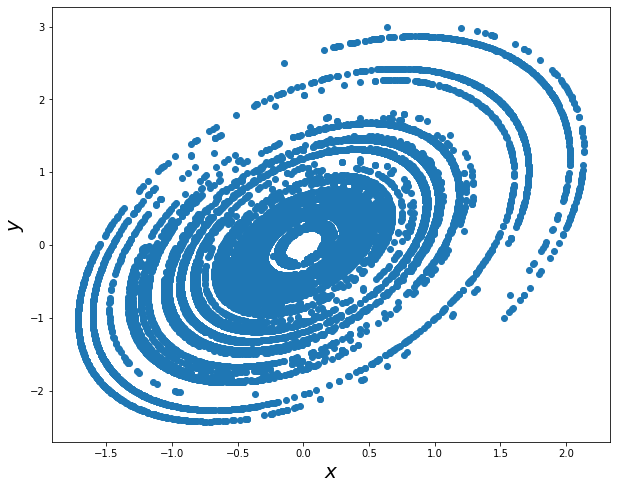

In [77]:
fig, ax = plt.subplots(figsize=(10, 8))
ax.scatter(new_corrected_samples[:, 0], new_corrected_samples[:,1])
#ax.contour(x_grid, y_grid, contour_values, colors="lightblue")
ax.set_xlabel(r"$x$", fontsize=20)
ax.set_ylabel(r"$y$", fontsize=20)
plt.show()

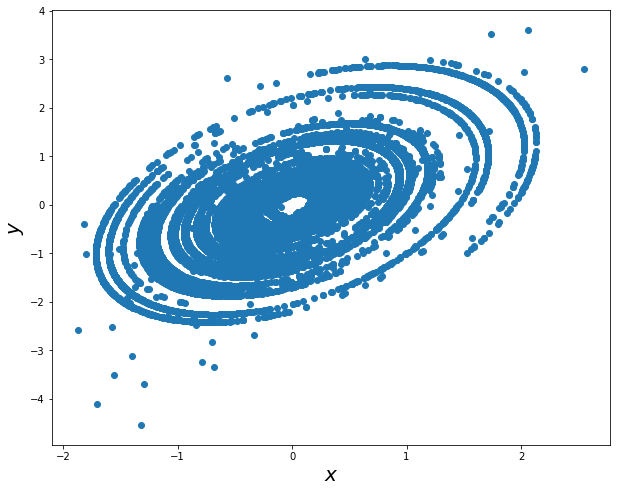

In [78]:
# add back the bloody hmc samples
new_new = samples
new_new[flags == 1] = new_corrected_samples
fig, ax = plt.subplots(figsize=(10, 8))
ax.scatter(new_new[:, 0], new_new[:,1])
#ax.contour(x_grid, y_grid, contour_values, colors="lightblue")
ax.set_xlabel(r"$x$", fontsize=20)
ax.set_ylabel(r"$y$", fontsize=20)
plt.show()

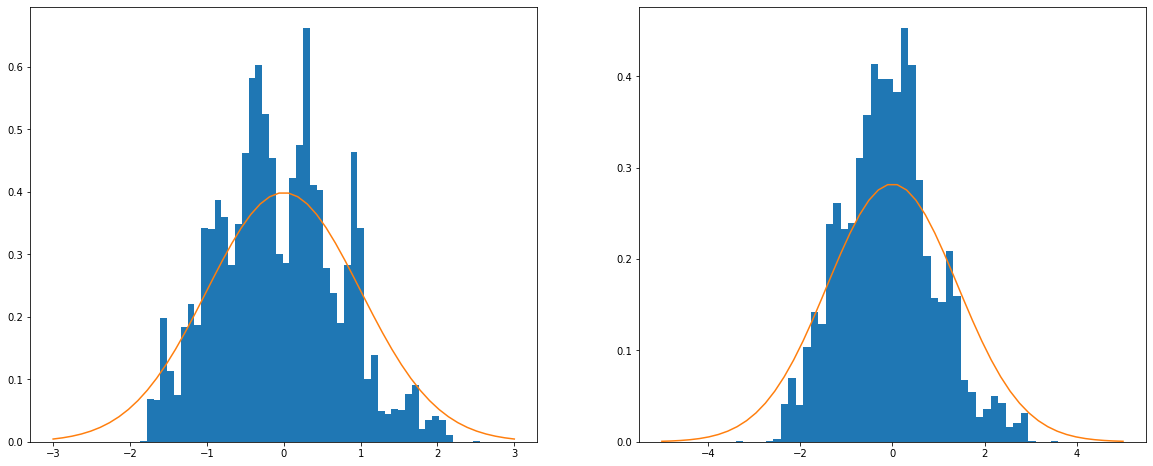

In [79]:
# marginals
marginal_x = norm(loc=mu[0], scale=np.sqrt(Sigma[0,0]))
marginal_y = norm(loc=mu[1], scale=np.sqrt(Sigma[1,1]))

# Plotting vars
xs = np.linspace(-3, 3)
ys = np.linspace(-5, 5)

fig, ax = plt.subplots(ncols=2, figsize=(20, 8))

# X space
_ = ax[0].hist(new_new[:, 0], bins=50, density=True)
ax[0].plot(xs, marginal_x.pdf(xs))

# Y space
_ = ax[1].hist(new_new[:, 1], bins=50, density=True)
ax[1].plot(ys, marginal_y.pdf(ys))

plt.show()

# Adding back hmc samples

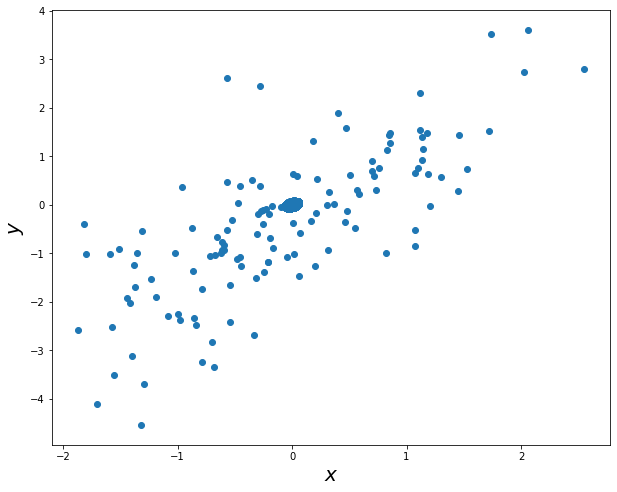

In [69]:
# replace old zappa samples with corrected ones
new = samples
new[flags == 1] = corrected_samples
fig, ax = plt.subplots(figsize=(10, 8))
ax.scatter(new[:, 0], new[:,1])
#ax.contour(x_grid, y_grid, contour_values, colors="lightblue")
ax.set_xlabel(r"$x$", fontsize=20)
ax.set_ylabel(r"$y$", fontsize=20)
plt.show()

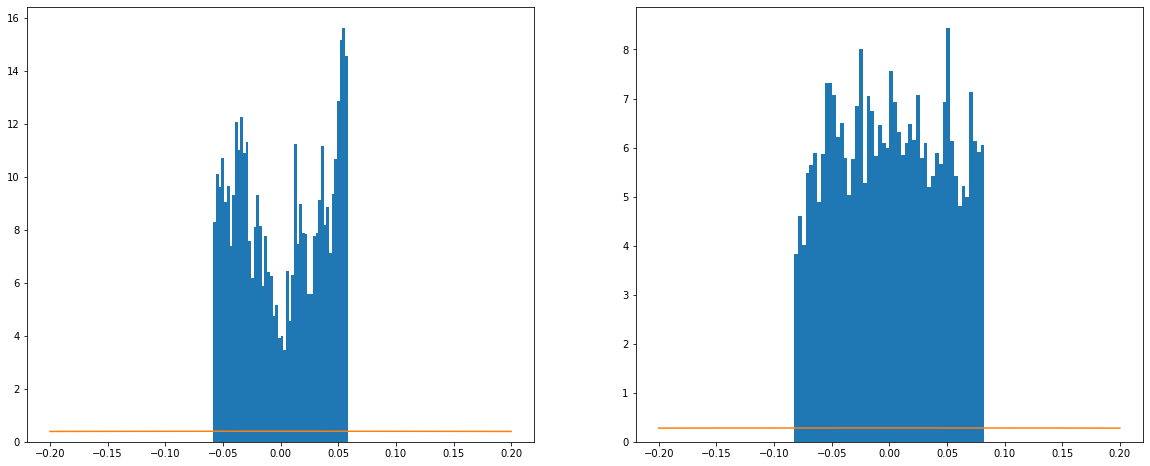

In [48]:
# marginals
marginal_x = norm(loc=mu[0], scale=np.sqrt(Sigma[0,0]))
marginal_y = norm(loc=mu[1], scale=np.sqrt(Sigma[1,1]))

# Plotting vars
xs = np.linspace(-0.2, 0.2)
ys = np.linspace(-1, 1)

fig, ax = plt.subplots(ncols=2, figsize=(20, 8))

# X space
_ = ax[0].hist(corrected_samples[:, 0], bins=50, density=True)
ax[0].plot(xs, marginal_x.pdf(xs))

# Y space
_ = ax[1].hist(corrected_samples[:, 1], bins=50, density=True)
ax[1].plot(ys, marginal_y.pdf(ys))

plt.show()